# RL implementation

In [1]:
import os, sys
import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
import text_flappy_bird_gym

### Environment

The following code displays the text environment.
At every step, the code chooses a random action. Hence, you'll see that the performance of this code is terrible.

In [3]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

while True:
    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(.1) # FPS
    
    clear_output(wait=True)
    
    # If player is dead break
    if done:
        break

env.close()

Text Flappy Bird!
Score: 0
----------------------
[               |    ]
[               |    ]
[               |    ]
[               |    ]
[               |    ]
[               |    ]
[                    ]
[                    ]
[                    ]
[                    ]
[               |    ]
[               |    ]
[               |    ]
[               |    ]
[     *         |    ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=9,dy=7)


In [4]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

info = obs[1]


while True:
    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)
    
    if type(obs[0]) == tuple:
        x, y = obs[0]
    else:
        x, y = obs
    
    if y > 0:
        action = 1
    elif y <= 0:
        action = 0
    elif y <= -3:
        action = 1
    
    
    if info['player'][0] >= 10: 
        action = 1
    

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(.1) # FPS
    
    clear_output(wait=True)
    

    # If player is dead break
    if done:
        break

env.close()

Text Flappy Bird!
Score: 16
----------------------
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[            |       ]
[            |       ]
[            |       ]
[            |       ]
[  |         |       ]
[  |         |       ]
[  |                 ]
[  |                 ]
[  |                 ]
[  |                 ]
[  |  *      |       ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=6,dy=3)


## Method 1 : Q-learning: Off-policy TD Control

### Distance to the next pipe gap

This implementation is based on the eponymous section 6.5 from __Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.__

First, we need to determine the possible states.

In this environment, we will consider the states as the tuples (x, y) where x and y are respectively the longitudinal and vertical distances to the center of the closest upcoming pipe gap.

Given the setup of the environment :
- x can take integer values from 0 to width (=20)
- y can take integer values from -height (=-15) to height (=15)

In [5]:
class Q_learning_flappy_bird_v1():
    def __init__(self, env, width, height, pipe_gap):
        
        self.width = width
        self.height = height
        self.pipe_gap = pipe_gap
        self.env = env
        
        n_x_states = self.width
        n_y_states = 2 * self.height
        self.state_space_x = list(range(self.width))
        self.state_space_y = list(range(-self.height, self.height))
        
        self.Q = np.random.rand(n_x_states, n_y_states, 2) * 10
        # Terminal conditions
        self.Q[0, :, :] = 0
        
        self.score_history = []
        self.death_causes = []
        
        self.death_cause_play = None
        self.score_play = None
    
    
    def _distance_to_state(self, x, y):
        """
        Returns the index of the state given distances x and y.
        """
        state_x = self.state_space_x.index(x)
        state_y = self.state_space_y.index(y)
        return state_x, state_y
    
    
    def _argmax(self, q_values):
        """
        Returns the argmax equiprobably in case of ties.
        """
        top = float("-inf")
        
        ties = []
        for i in range(len(q_values)):
            if q_values[i] == top:
                ties.append(i)
            elif q_values[i] > top:
                ties = [i]
                top = q_values[i]
        
        ind = np.random.choice(ties)
        return ind

    
    def train(self, n_episodes, alpha, epsilon, show_episodes=True):
        """
        Trains the Q-Learning model.
        """
        top_score = float("-inf")
        
        for i in range(n_episodes):
            obs = self.env.reset()
            x, y = obs[0]
            x, y = self._distance_to_state(x, y)
            
            while True:
                # Select next action
                random_number = np.random.random()
                if random_number < epsilon:
                    action = self.env.action_space.sample()  # for an agent, action = agent.policy(observation)
                else:
                    action = self._argmax(self.Q[x, y, :])

                # Apply action and return new observation of the environment
                obs, reward, done, _, info = self.env.step(action)
                x_, y_ = obs
                score = info['score']
                if score > top_score:
                    top_score = score
                
                # If we die, we set the reward to -100.
                # If we manage to go through a gap, we set the reward to 10
                if done:
                    reward = -100
                    if x == 0:
                        self.death_causes.append("Collision")
                    else:
                        self.death_causes.append("Floor")
                elif x==0 and not done:
                    reward = 10
                
                self.Q[x, y, action] += alpha * (reward + np.max(self.Q[x_, y_, :] - self.Q[x, y, action]))
                
                x, y = x_, y_
                
                # Render the game
                if show_episodes:
                    os.system("clear")
                    print(f"Episode : {i+1}/{n_episodes}")
                    print("Top score :", top_score)
                    sys.stdout.write(self.env.render())
                    #time.sleep(.01) # FPS

                    clear_output(wait=True)

                # If player is dead break
                if done:
                    break
            
            self.score_history.append(score)

        self.env.close()
        
        return self
    
    
    def play(self, display=True, sleep_time=0.1):
        obs = self.env.reset()
        x, y = obs[0]
        x, y = self._distance_to_state(x, y)

        while True:
            # Select next action
            action = self._argmax(self.Q[x, y, :])

            # Apply action and return new observation of the environment
            obs, reward, done, _, info = self.env.step(action)
            x, y = obs
            
            if done:
                if x == 0:
                    self.death_cause_play = "Collision"
                else:
                    self.death_cause_play = "Floor"

            # Render the game
            if display:
                os.system("clear")
                sys.stdout.write(env.render())
                if sleep_time:
                    time.sleep(.1) # FPS

                clear_output(wait=True)

            # If player is dead break
            if done:
                self.score_play = info['score']
                break

        env.close()
        
        return self
        
        

In [6]:
height = 15
width = 20
pipe_gap = 4

env = gym.make('TextFlappyBird-v0', 
               height = height, 
               width = width, 
               pipe_gap = pipe_gap)

q_learning_v1 = Q_learning_flappy_bird_v1(env=env, 
                                         width = width, 
                                         height = height, 
                                         pipe_gap = pipe_gap)

Example of training :

In [7]:
n_episodes = 100
alpha = 0.1
epsilon = 0.1

train_model = q_learning_v1.train(n_episodes=n_episodes,
                                  alpha=alpha,
                                  epsilon=epsilon)

Episode : 100/100
Top score : 11
Text Flappy Bird!
Score: 0
----------------------
[      |         |   ]
[     *|         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[                    ]
[                    ]
[                    ]
[                    ]
[      |         |   ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=0,dy=-11)


#### Performance review

In [22]:
height = 15
width = 20
pipe_gap = 4

env = gym.make('TextFlappyBird-v0', 
               height = height, 
               width = width, 
               pipe_gap = pipe_gap)

q_learning_v1 = Q_learning_flappy_bird_v1(env=env, 
                                          width = width, 
                                          height = height, 
                                          pipe_gap = pipe_gap)

In [23]:
alpha = 0.1
epsilon = 0.1

start_n_episodes = 10
end_n_episodes = 2000
n_steps = 10

episodes_array = np.linspace(start_n_episodes, end_n_episodes, n_steps).astype(int)
episodes_increments = [start_n_episodes] + list(np.diff(episodes_array))

raw_results = []
median_scores = []

for i, n_episodes in enumerate(episodes_increments):
    train_model = q_learning_v1.train(n_episodes=n_episodes,
                                      alpha=alpha,
                                      epsilon=epsilon,
                                      show_episodes=False)

    n_plays = 100
    print(f"Training with {episodes_array[i]} episodes :")
    scores = []
    for _ in tqdm(range(n_plays)):
        model = q_learning_v1.play(False, sleep_time=0)
        scores.append(model.score_play)
    
        
    median_scores.append(np.median(scores))

Training with 10 episodes :


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2237.39it/s]


Training with 231 episodes :


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 462.21it/s]


Training with 452 episodes :


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 252.91it/s]


Training with 673 episodes :


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.26it/s]


Training with 894 episodes :


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 111.31it/s]


Training with 1115 episodes :


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.31it/s]


Training with 1336 episodes :


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.75it/s]


Training with 1557 episodes :


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.21it/s]


Training with 1778 episodes :


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:16<00:00,  4.36s/it]


Training with 2000 episodes :


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:01<00:00,  4.81s/it]


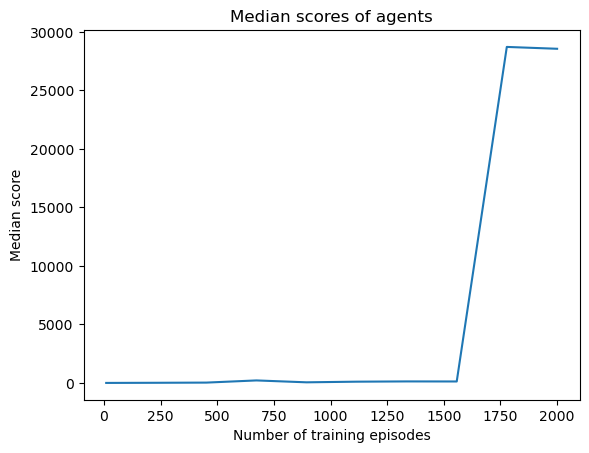

In [27]:
plt.plot(episodes_array, median_scores)

plt.title("Median scores of agents")

plt.xlabel("Number of training episodes")
plt.ylabel("Median score")

plt.show()

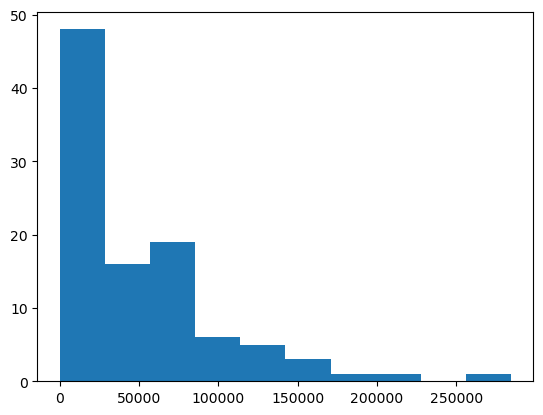

In [31]:
plt.hist(scores, bins=10)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (173,) and (1951,)

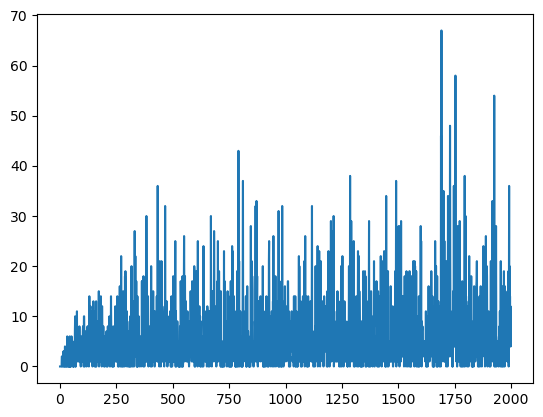

In [32]:
plt.plot(q_learning_v1.score_history, label='True scores')

window_size = 50
moving_average_scores = np.convolve(q_learning_v1.score_history, np.ones(window_size), 'valid') / window_size
plt.plot(list(range(n_episodes))[window_size-1:], moving_average_scores, label="Moving average")

plt.xlabel("Episode")
plt.ylabel("Score")

plt.legend()

plt.show()

The distribution of scores :

In [54]:
n_experiments = 1000

experiment_scores = []
experiment_death_cause = []

for i in tqdm(range(n_experiments)):
    model = q_learning_v1.play(False)
    experiment_scores.append(model.score_play)
    experiment_death_cause.append(model.death_cause_play)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:10<00:00, 14.09it/s]


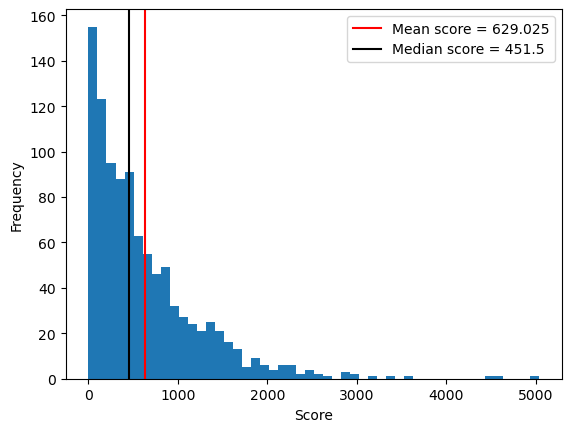

In [55]:
plt.hist(experiment_scores, bins=50)

mean_score = np.mean(experiment_scores)
median_score = np.median(experiment_scores)

plt.axvline(mean_score, color='r', label=f"Mean score = {mean_score}")
plt.axvline(median_score, color='k', label=f"Median score = {median_score}")


plt.xlabel("Score")
plt.ylabel("Frequency")

plt.legend()

plt.show()

Let's examine the causes of death.

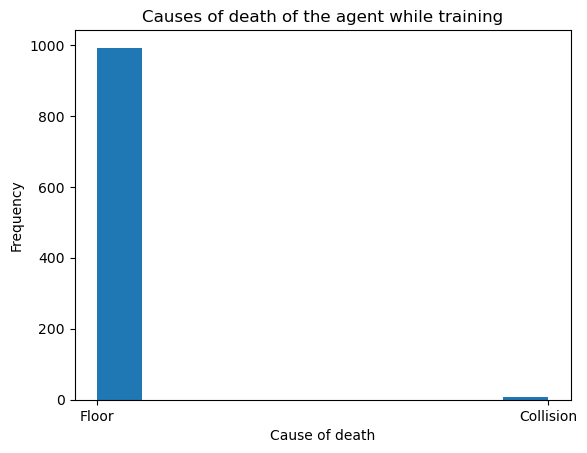

In [10]:
plt.hist(q_learning.death_causes)

plt.title("Causes of death of the agent while training")

plt.xlabel("Cause of death")
plt.ylabel("Frequency")

plt.show()

In [12]:
q_learning.play()

Text Flappy Bird!
Score: 22
----------------------
[         |          ]
[         |          ]
[      @             ]
[                    ]
[                    ]
[                    ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
[         |          ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=3,dy=-2)


KeyboardInterrupt: 

### Distance to the next pipe gap and to the floor

So as to avoid the collisitions with the floor, we will add another dimension to our state space that incapsulses the information of the distance to the groud. The implementation will be very similar to what we did before in `Q_learning_flappy_bird_v1`.

In [13]:
class Q_learning_flappy_bird_v2():
    def __init__(self, env, width, height, pipe_gap):
        
        self.width = width
        self.height = height
        self.pipe_gap = pipe_gap
        self.env = env
        
        n_x_states = self.width
        n_y_states = 2 * self.height
        n_h_states = self.height
        self.state_space_x = list(range(self.width))
        self.state_space_y = list(range(-self.height, self.height))
        self.state_space_h = list(range(1, self.height + 1))
        
        self.Q = np.random.rand(n_x_states, n_y_states, n_h_states, 2) * 10
        # Terminal conditions
        self.Q[0, :, :, :] = 0      # x = 0
        self.Q[:, :, -1, :] = 0     # h = 15 the height is measured from the top-down
        
        self.score_history = []
        self.death_causes = []
        
        self.death_cause_play = None
        self.score_play = None
    
    
    def _distance_to_state(self, x, y, h):
        """
        Returns the index of the state given distances x and y.
        """
        state_x = self.state_space_x.index(x)
        state_y = self.state_space_y.index(y)
        state_h = self.state_space_h.index(h)
        return state_x, state_y, state_h
    
    
    def _argmax(self, q_values):
        """
        Returns the argmax equiprobably in case of ties.
        """
        top = float("-inf")
        
        ties = []
        for i in range(len(q_values)):
            if q_values[i] == top:
                ties.append(i)
            elif q_values[i] > top:
                ties = [i]
                top = q_values[i]
        
        ind = np.random.choice(ties)
        return ind

    
    def train(self, n_episodes, alpha, epsilon, show_episodes=True):
        """
        Trains the Q-Learning model.
        """
        top_score = float("-inf")
        
        for i in range(n_episodes):
            obs = self.env.reset()
            x, y = obs[0]
            h = 8
            x, y, h = self._distance_to_state(x, y, h)
            
            while True:
                # Select next action
                random_number = np.random.random()
                if random_number < epsilon:
                    action = self.env.action_space.sample()  # for an agent, action = agent.policy(observation)
                else:
                    action = self._argmax(self.Q[x, y, h, :])

                # Apply action and return new observation of the environment
                obs, reward, done, _, info = self.env.step(action)
                x_, y_ = obs
                h_ = info['player'][1]
                score = info['score']
                if score > top_score:
                    top_score = score
                
                # If we die, we set the reward to -100.
                # If we manage to go through a gap, we set the reward to 10
                if done:
                    reward = -100
                    if x == 0:
                        self.death_causes.append("Collision")
                    elif h == self.height - 1:
                        self.death_causes.append("Floor")
                    else:
                        self.death_causes.append("Bizarre")
                elif x==0 and not done:
                    reward = 10
                
                self.Q[x, y, action] += alpha * (reward + np.max(self.Q[x_, y_, :] - self.Q[x, y, action]))
                
                x, y, h = x_, y_, h_
                
                # Render the game
                if show_episodes:
                    os.system("clear")
                    print(f"Episode : {i+1}/{n_episodes}")
                    print("Top score :", top_score)
                    sys.stdout.write(self.env.render())
                    #time.sleep(.01) # FPS

                    clear_output(wait=True)

                # If player is dead break
                if done:
                    break
            
            self.score_history.append(score)

        self.env.close()
        
        return self
    
    
    def play(self, show_episodes=True):
        obs = self.env.reset()
        x, y = obs[0]
        h = 8
        x, y, h = self._distance_to_state(x, y, h)

        while True:
            # Select next action
            action = self._argmax(self.Q[x, y, h, :])

            # Apply action and return new observation of the environment
            obs, reward, done, _, info = self.env.step(action)
            x, y = obs
            h = info['player'][1]
            
            if done:
                if x == 0:
                    self.death_cause_play = "Collision"
                elif h == self.height - 1:
                    self.death_cause_play = "Floor"
            
            # Render the game
            if show_episodes:
                os.system("clear")
                sys.stdout.write(env.render())
                time.sleep(.1) # FPS

                clear_output(wait=True)

            # If player is dead break
            if done:
                self.score_play = info['score']
                break

        env.close()
    
        return self
        
        

In [14]:
height = 15
width = 20
pipe_gap = 4

env = gym.make('TextFlappyBird-v0', 
               height = height, 
               width = width, 
               pipe_gap = pipe_gap)

q_learning_v2 = Q_learning_flappy_bird_v1(env=env, 
                                         width = width, 
                                         height = height, 
                                         pipe_gap = pipe_gap)

In [ ]:
n_episodes = 500
alpha = 0.1
epsilon = 0.1

train_model_2 = q_learning_v2.train(n_episodes=n_episodes,
                                    alpha=alpha,
                                    epsilon=epsilon)

Episode : 157/1000
Top score : 258
Text Flappy Bird!
Score: 21
----------------------
[       |         |  ]
[       |         |  ]
[       |            ]
[       |            ]
[       |            ]
[       |            ]
[       |         |  ]
[       |         |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=1,dy=1)
Episode : 157/1000
Top score : 258
Text Flappy Bird!
Score: 21
----------------------
[       |         |  ]
[       |         |  ]
[       |            ]
[       |            ]
[       |            ]
[       |            ]
[       |         |  ]
[       |         |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe 

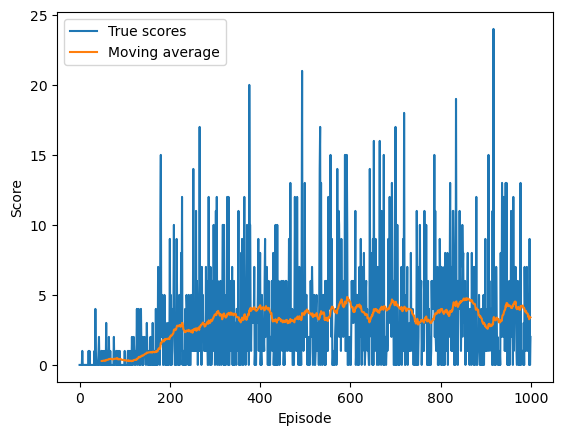

In [25]:
plt.plot(q_learning_v2.score_history, label='True scores')

window_size = 50
moving_average_scores = np.convolve(q_learning_v2.score_history, np.ones(window_size), 'valid') / window_size
plt.plot(list(range(n_episodes))[window_size-1:], moving_average_scores, label="Moving average")

plt.xlabel("Episode")
plt.ylabel("Score")

plt.legend()

plt.show()

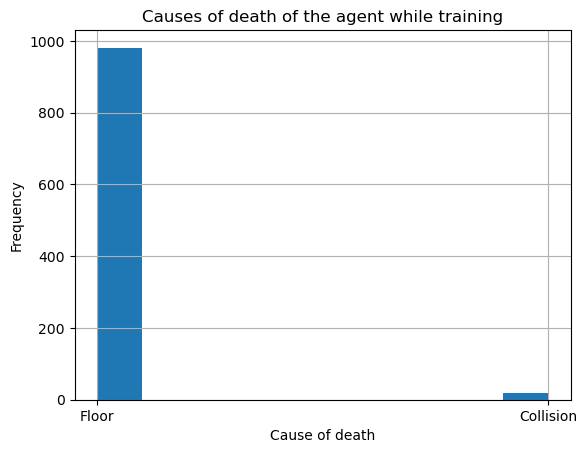

In [28]:
plt.hist(q_learning_v2.death_causes)

plt.title("Causes of death of the agent while training")

plt.xlabel("Cause of death")
plt.ylabel("Frequency")

plt.grid()

plt.show()

In [29]:
q_learning_v2.play()

Text Flappy Bird!
Score: 25
----------------------
[   |         |      ]
[   |         |      ]
[   |         |      ]
[      @      |      ]
[             |      ]
[             |      ]
[             |      ]
[   |         |      ]
[   |         |      ]
[   |         |      ]
[   |                ]
[   |                ]
[   |                ]
[   |                ]
[   |         |      ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=7,dy=-9)


KeyboardInterrupt: 

In [32]:
q_learning_v2.env.close()